Group: 19

Name:

Yogita Ambure(202101070199)(233)

Riya Hulule(202101070194)(229)

Division:B(B2)

Pneumonia Detection Using Deep Learning with VGG16

Introduction Background Pneumonia is a serious lung infection that can be caused by viruses, bacteria, or fungi. It leads to inflammation in the air sacs of the lungs, often filling them with fluid, making breathing difficult. Pneumonia can be fatal if left untreated, especially for children, the elderly, and individuals with weakened immune systems. Early diagnosis is crucial for effective treatment.

The conventional method of diagnosing pneumonia involves the interpretation of chest X-rays by radiologists. However, manual analysis of X-rays can be time-consuming and prone to human error. Therefore, the automation of pneumonia detection using deep learning techniques is of significant interest. In this project, we utilize (Convolutional Neural Networks (CNNs) ) VGG16 to classify chest X-rays into two categories: "Normal" and "Pneumonia".

Problem Statement

*The objective of this project is to develop a highly accurate pneumonia detection model using chest X-ray images. *
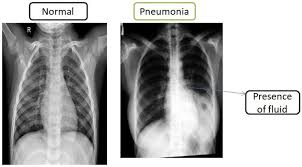

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Necessary Libraries

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam  # Ensure Adam is imported
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [ ]:
import os

def list_files_in_directory(base_dir):
    for root, dirs, files in os.walk(base_dir):
        if files:  # Only show directories with files
            print(f"\nDirectory: {root}")
            print(f"Total Files: {len(files)}")
            print(f"Files: {files[:5]}")  # Show only first 5 files for brevity

# Set the base directory to the dataset directory
dataset_dir = 'dataset'  # Update with your path

# List files in train, val, and test directories
print("Training Set:")
list_files_in_directory(os.path.join(dataset_dir, 'train'))

print("\nValidation Set:")
list_files_in_directory(os.path.join(dataset_dir, 'val'))

print("\nTest Set:")
list_files_in_directory(os.path.join(dataset_dir, 'test'))


Training Set:

Directory: drive/MyDrive/dataset/train
Total Files: 1
Files: ['.DS_Store']

Directory: drive/MyDrive/dataset/train/NORMAL
Total Files: 838
Files: ['IM-0117-0001.jpeg', 'IM-0125-0001.jpeg', 'IM-0129-0001.jpeg', 'IM-0127-0001.jpeg', 'IM-0131-0001.jpeg']

Validation Set:

Directory: drive/MyDrive/dataset/val
Total Files: 1
Files: ['.DS_Store']

Directory: drive/MyDrive/dataset/val/NORMAL
Total Files: 9
Files: ['.DS_Store', 'NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1440-0001.jpeg']

Directory: drive/MyDrive/dataset/val/PNEUMONIA
Total Files: 9
Files: ['person1954_bacteria_4886.jpeg', 'person1951_bacteria_4882.jpeg', 'person1950_bacteria_4881.jpeg', 'person1946_bacteria_4874.jpeg', 'person1949_bacteria_4880.jpeg']

Test Set:

Directory: drive/MyDrive/dataset/test/PNEUMONIA
Total Files: 390
Files: ['person109_bacteria_522.jpeg', 'person108_bacteria_507.jpeg', 'person109_bacteria_517.jpeg', 'person112_bacteria_539.jpeg', 

In [ ]:
# Define directories
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

In [12]:
def count_images(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

train_count = count_images(train_dir)
val_count = count_images(val_dir)
test_count = count_images(test_dir)

print(f'Training images: {train_count}')
print(f'Validation images: {val_count}')
print(f'Test images: {test_count}')


Training images: 4715
Validation images: 19
Test images: 624


Data Exploration and Analysis

Understanding your dataset is crucial before training a model. Here, we count the number of images in each class (NORMAL and PNEUMONIA) across the training, validation, and test datasets. This helps us get an idea of class distribution and check for any data imbalances.

Next, we visualize a few images from the dataset to observe the variations between the NORMAL and PNEUMONIA categories. Visualization is helpful in getting a better sense of what the model will be learning.

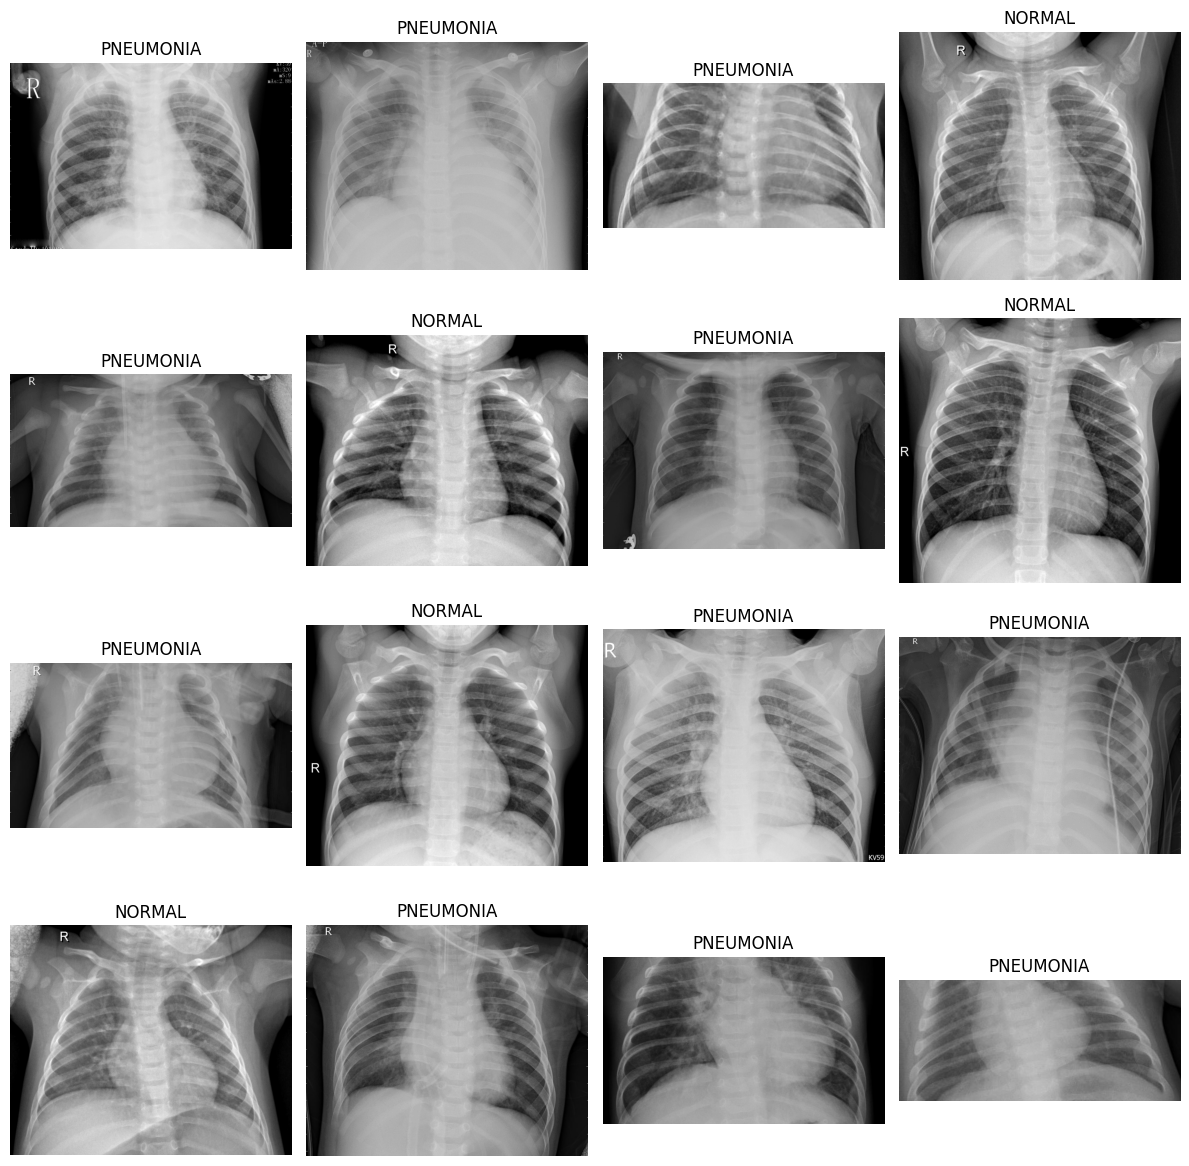

In [29]:
def plot_images_from_directory(directory, num_images=16):
    # Get categories (subdirectories) and ignore non-directory files
    categories = [cat for cat in os.listdir(directory) if os.path.isdir(os.path.join(directory, cat))]

    # Set up the figure for plotting
    plt.figure(figsize=(12, 12))

    # Randomly choose 'num_images' images from the categories
    for i in range(num_images):
        category = random.choice(categories)  # Randomly choose a category
        category_dir = os.path.join(directory, category)  # Get the directory for that category
        img_path = os.path.join(category_dir, random.choice(os.listdir(category_dir)))  # Randomly choose an image
        img = mpimg.imread(img_path)  # Read the image

        # Create a subplot for the image
        plt.subplot(4, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{category}')
        plt.axis('off')  # Hide axis

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

# Visualize training data
plot_images_from_directory(train_dir)

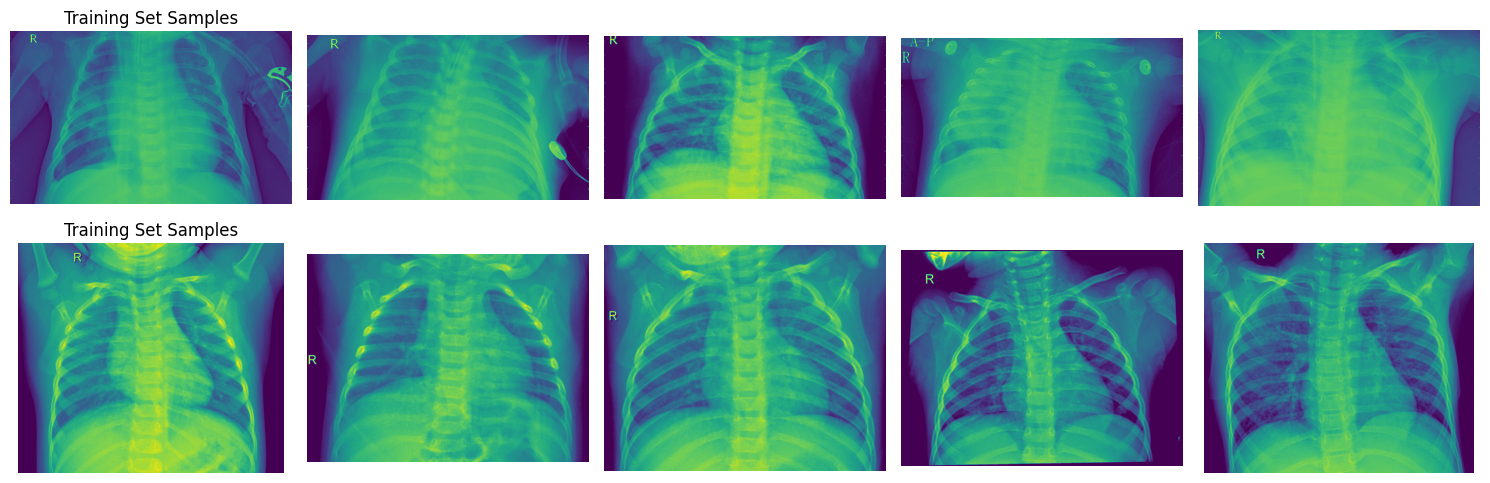

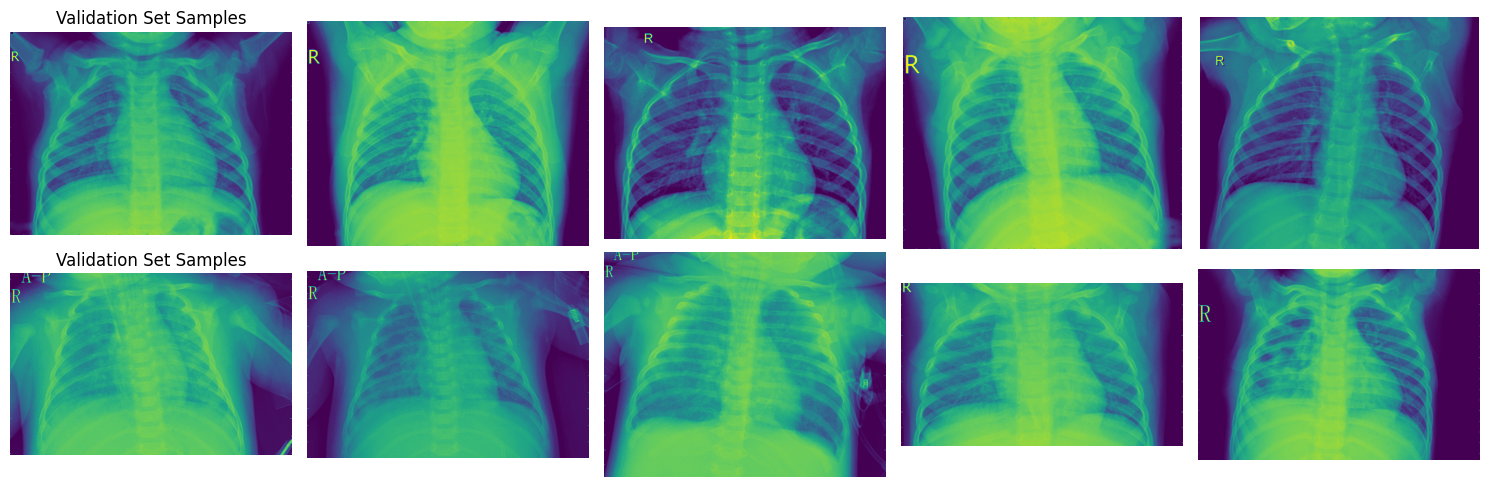

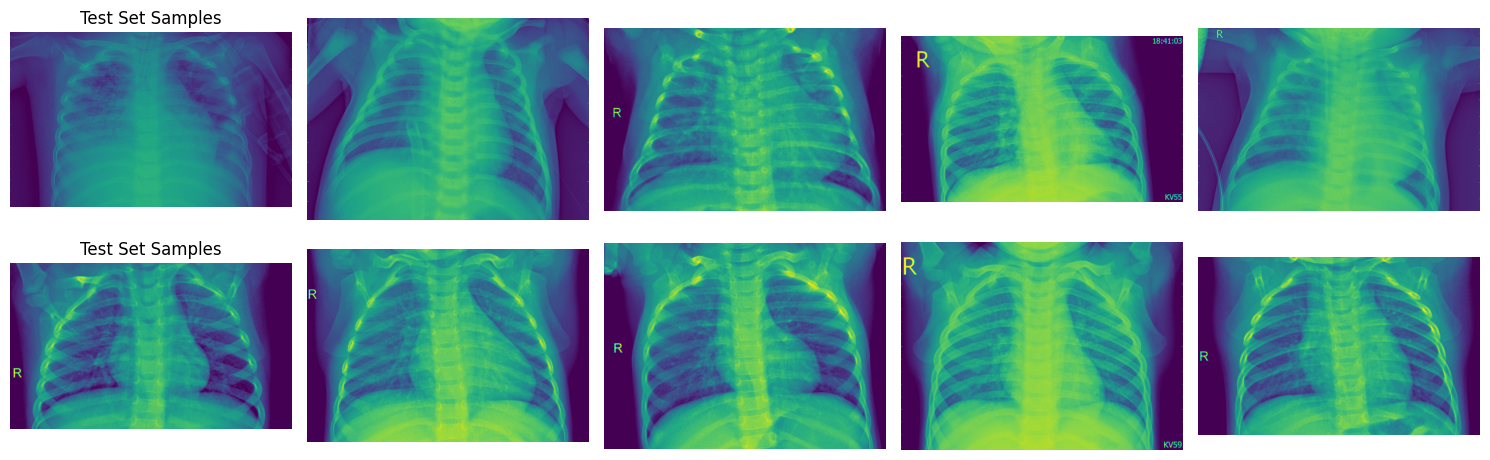

In [ ]:
import os
import random
import matplotlib.pyplot as plt

# Define the dataset directory paths
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

def plot_sample_images(data_dir, title, num_images=5):
    # Get all classes (subdirectories) in the given directory
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)

        # Get all image files in the class directory
        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select images
        selected_images = random.sample(images, min(num_images, len(images)))

        for j, image_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, image_name)
            img = plt.imread(img_path)  # Read the image
            plt.subplot(len(classes), num_images, i * num_images + j + 1)  # Create subplot
            plt.imshow(img)  # Show the image
            plt.axis('off')  # Hide axes
            if j == 0:
                plt.title(title )  # Title for each class

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

# Display sample images from the training dataset
plot_sample_images(train_dir, "Training Set Samples", num_images=5)

# Display sample images from the validation dataset
plot_sample_images(val_dir, "Validation Set Samples", num_images=5)

# Display sample images from the test dataset
plot_sample_images(test_dir, "Test Set Samples", num_images=5)


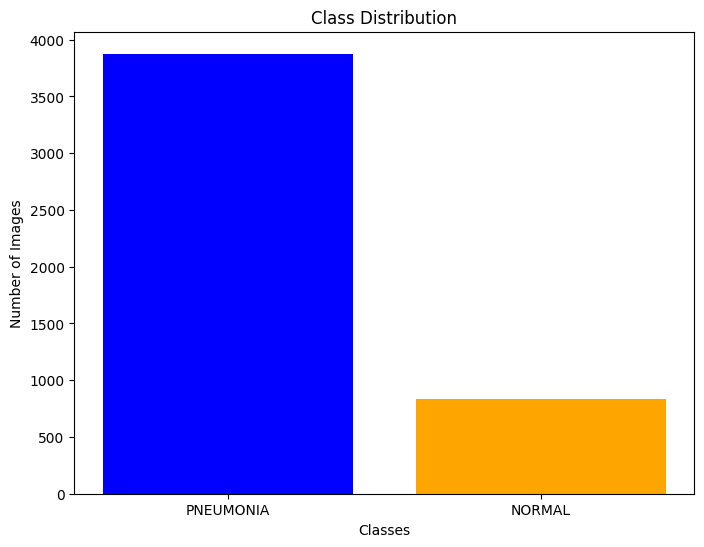

In [20]:
def plot_class_distribution(directory):
    # Get classes and ignore non-directory files
    classes = [cls for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))]
    class_counts = [len(os.listdir(os.path.join(directory, cls))) for cls in classes]

    plt.figure(figsize=(8, 6))
    plt.bar(classes, class_counts, color=['blue', 'orange'])
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

# Plot class distribution for training data
plot_class_distribution(train_dir)


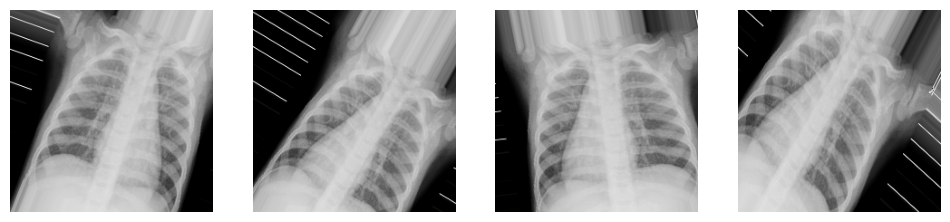

In [23]:
def plot_augmentations(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images
    it = datagen.flow(img_array, batch_size=1)

    plt.figure(figsize=(12, 6))
    for i in range(4):
        # Use next(it) instead of it.next()
        batch = next(it)
        augmented_image = batch[0].astype('float32') / 255.0
        plt.subplot(1, 4, i+1)
        plt.imshow(augmented_image)
        plt.axis('off')
    plt.show()

# Example: Plot augmentations for a sample image
sample_img_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
plot_augmentations(sample_img_path)




Data Preprocessing

Raw image data needs to be preprocessed to make it suitable for feeding into the model. Preprocessing includes:

Data Augmentation: Data augmentation helps in improving the model's generalization by artificially increasing the training dataset size. Techniques like rotation, zoom, horizontal flipping, etc., are applied to the training images, which helps the model generalize better to unseen data.

Rescaling: All pixel values are rescaled from [0, 255] to [0, 1] to normalize the data, which speeds up the convergence of the model.

Image Data Generators: These generators will preprocess the data in real-time during training, which is efficient when working with large image datasets. The ImageDataGenerator class in Keras is used for this purpose.

In [24]:
# Image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Test data
test_datagen = ImageDataGenerator(rescale=1./255)



In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4712 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model Building Using VGG16

Building the Model We are using VGG16, a popular CNN architecture that has been pre-trained on the ImageNet dataset. Transfer learning allows us to use the learned features of this pre-trained model to classify pneumonia. The base model is kept frozen initially, and only the newly added dense layers are trained.

Key steps:

Freezing Layers: The pre-trained layers of VGG16 are frozen because they contain useful features learned from ImageNet. This prevents them from being updated during training.

Adding New Layers: We add custom layers such as Dense and Dropout to adapt VGG16 for our binary classification task (pneumonia vs. normal).

Compilation: The model is compiled using the Adam optimizer, and the loss function used is binary cross-entropy since this is a binary classification problem.

In [38]:

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [37]:
# Step 7: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

Train the Model

We train the model for a certain number of epochs and monitor the validation performance to ensure it generalizes well to unseen data.

In [ ]:
# Callbacks for early stopping, saving the best model, and reducing learning rate
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=(val_generator.samples // batch_size),
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20


c:\Users\ADITYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8082 - loss: 0.4540
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8084 - loss: 0.4534 - val_accuracy: 0.6250 - val_loss: 0.6689 - learning_rate: 1.0000e-05
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.9688 - loss: 0.1586

c:\Users\ADITYA\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.62500
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9688 - loss: 0.0798 - val_accuracy: 0.6250 - val_loss: 0.6792 - learning_rate: 1.0000e-05
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8872 - loss: 0.2446
Epoch 3: val_accuracy did not improve from 0.62500
147/147 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8873 - loss: 0.2445 - val_accuracy: 0.6250 - val_loss: 0.7040 - learning_rate: 1.0000e-05
Epoch 4/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.8750 - loss: 0.1912
Epoch 4: val_accuracy did not improve from 0.62500

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8750 - loss: 0.0963 - val_accuracy: 0.6250 - val_loss: 0.7024 - learning_rate: 1.0000e-05
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9075 - loss: 0.2044
Epoch 5: val_accuracy improved from 0.62500 to 0.68750, saving model to be

Model Evaluation

After training the model, it’s important to evaluate its performance on the test set, which the model has not seen during training.

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Thresholding at 0.5

# Get true labels
true_labels = test_generator.classes  # True labels from the generator


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7512 - loss: 0.5522
Test Accuracy: 0.84
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


In [ ]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes)
roc_auc = roc_auc_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.84
Precision: 0.82
Recall: 0.96
F1 Score: 0.89
ROC AUC Score: 0.94


In [ ]:
# Step 7: Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=['Normal', 'Pneumonia']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.65      0.76       234
   Pneumonia       0.82      0.96      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



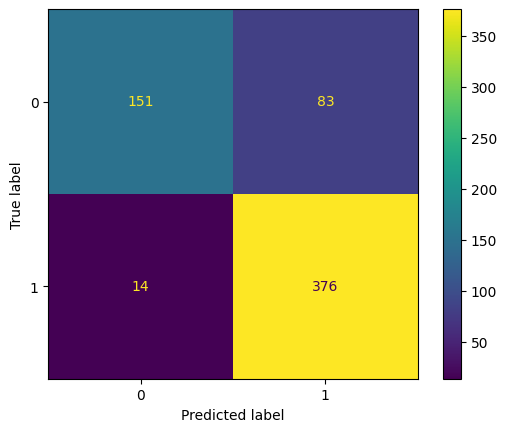

In [ ]:
# Step 7: Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

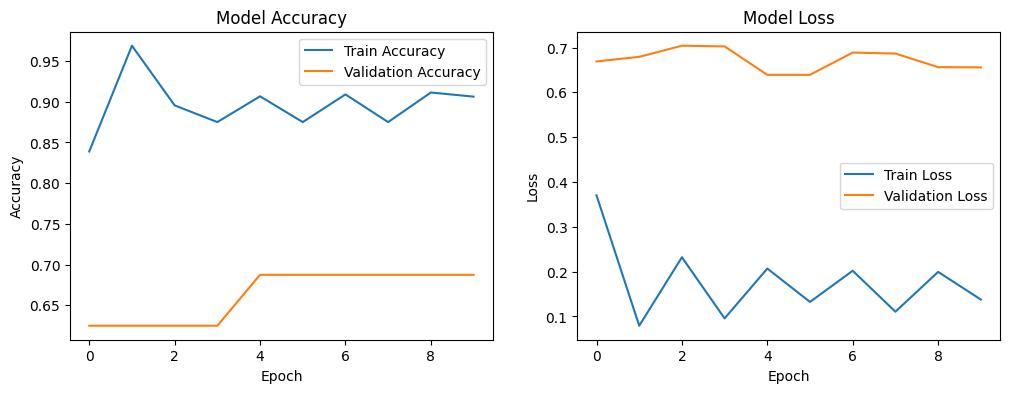

In [ ]:
# Step 8: Visualizing Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

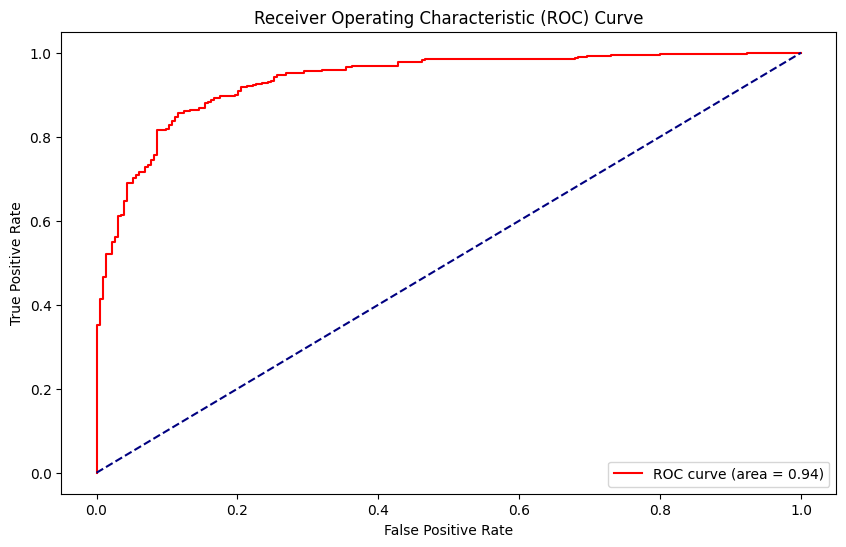

In [ ]:
# Step 9: ROC Curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

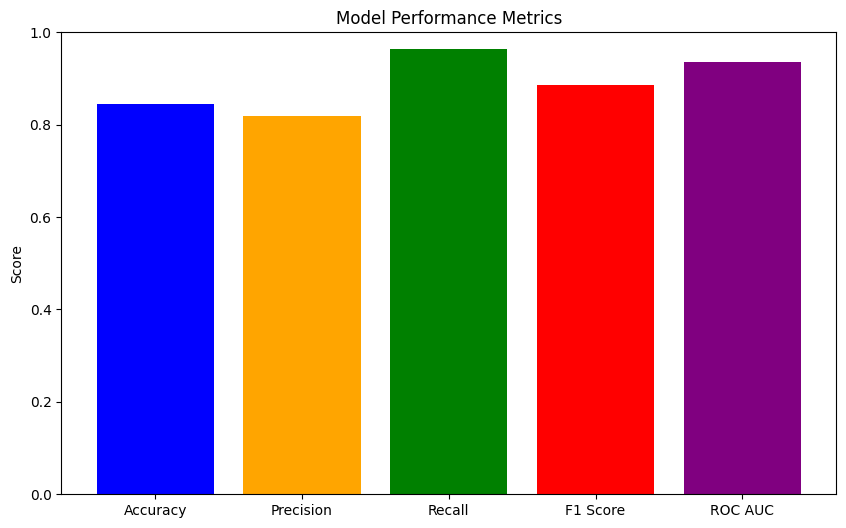

In [ ]:
# Step 12: Bar Chart of Performance Metrics
metrics = [accuracy, precision, recall, f1, roc_auc]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metrics, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


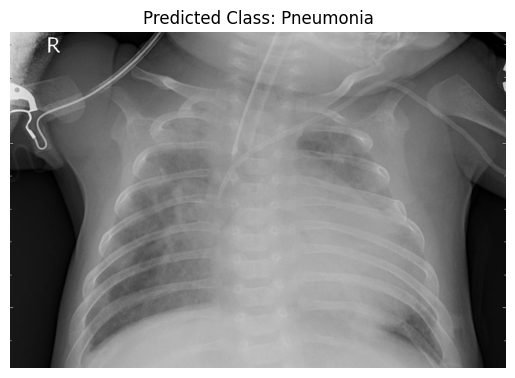

In [ ]:
# Step 2: Load and Preprocess a Test Image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

# Replace 'path_to_your_test_image' with the actual path to the image you want to test
test_image_path = 'dataset/test/PNEUMONIA/person1_virus_6.jpeg'  # Change this to the path of the user's image
preprocessed_image = load_and_preprocess_image(test_image_path)

# Step 3: Make Prediction
prediction = model.predict(preprocessed_image)
predicted_class = (prediction > 0.5).astype(int).flatten()[0]  # Thresholding at 0.5

# Display the image and prediction result
plt.imshow(image.load_img(test_image_path))
plt.title(f'Predicted Class: {"Pneumonia" if predicted_class == 1 else "Normal"}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


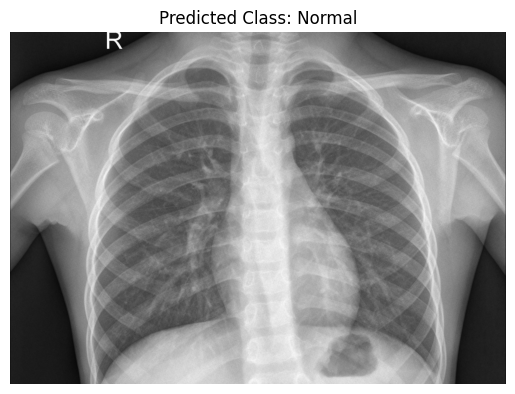

In [ ]:
# Step 2: Load and Preprocess a Test Image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

# Replace 'path_to_your_test_image' with the actual path to the image you want to test
test_image_path = 'dataset/test/NORMAL/IM-0001-0001.jpeg'  # Change this to the path of the user's image
preprocessed_image = load_and_preprocess_image(test_image_path)

# Step 3: Make Prediction
prediction = model.predict(preprocessed_image)
predicted_class = (prediction > 0.5).astype(int).flatten()[0]  # Thresholding at 0.5

# Display the image and prediction result
plt.imshow(image.load_img(test_image_path))
plt.title(f'Predicted Class: {"Pneumonia" if predicted_class == 1 else "Normal"}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


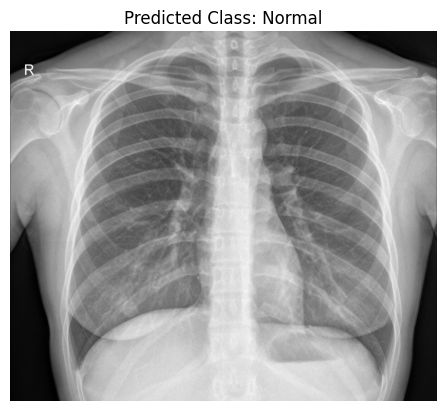

In [ ]:
# Step 2: Load and Preprocess a Test Image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

# Replace 'path_to_your_test_image' with the actual path to the image you want to test
test_image_path = 'image1.jpeg'  # Change this to the path of the user's image
preprocessed_image = load_and_preprocess_image(test_image_path)

# Step 3: Make Prediction
prediction = model.predict(preprocessed_image)
predicted_class = (prediction > 0.5).astype(int).flatten()[0]  # Thresholding at 0.5

# Display the image and prediction result
plt.imshow(image.load_img(test_image_path))
plt.title(f'Predicted Class: {"Pneumonia" if predicted_class == 1 else "Normal"}')
plt.axis('off')
plt.show()